# PYROSETTA.DISTRIBUTED - RosettaScripts/Python Interface Integration

## Integration Components
The python software ecosystem relies on a small set of shared core interfaces utilizing primitive language-native data structures, pure function invocation, and object serialization to provide loosely coupled interoperability between independent software components. Our component, the `pyrosetta.distributed` namespace, utilizes established elements of the Rosetta internal architecture: the Pose model & score representation, RosettaScript protocols, and Pose serialization. 

The adoption of a small set of core interfaces supports integration with an array of scientific computing tools, including support for interactive development environments, common record-oriented data formats, statistical analysis and machine learning packages, and multiple distributed computing packages. The pyrosetta.distributed package provides example integrations with several preferred packages for data analysis (Pandas), distributed computing (Dask), and interactive development (Jupyter Notebook), but is loosely coupled to allow later integration with additional libraries.

In [1]:
import pyrosetta.distributed

# Distributed components perform default initialization on-demand, but 
# can be request custom initialization via
pyrosetta.distributed.maybe_init()

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2019.22+release.d8f9b4a90a8f2caa32948bacdb6e551591facd5f 2019-05-30T13:47:16] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Data Structures (pyrosetta.distributed.packed_pose)
“Primitive” datatypes form a primary interface between many python libraries and, though not strictly defined, typically include the built-in scalar types (string, int, bool, float, ...), key-value dicts, and lists. Libraries operating on more complex user-defined classes often expose routines interconverting to and from primitive datatypes, and primitive datatypes can be efficiently serialized in multiple formats.
For interaction between Rosetta protocol components and external libraries, we developed the `pyrosetta.distributed.packed_pose` namespace. This implements an isomorphism between the Pose object and dict-like records of the molecular model and scores. The Pose class represents a mutable, full-featured molecular model with non-trivial memory footprint. A Pose may be inexpensively interconverted to a compact binary encoding via recently developed cereal-based serialization in the suite. This serialized format is used to implement the `PackedPose` class, an immutable record containing model scores and the encoded model, which is isomorphic to a dict-based record. Adaptor functions within the packed_pose namespace freely adapt between collections of Pose (`packed_pose.to_pose`), PackedPose (`packed_pose.to_packed`), dict-records (`packed_pose.to_dict`) and pandas.DataFrame objects. (Fig 2.A)

In [2]:
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.io as io
import requests
import pandas

ubq = io.pose_from_pdbstring(requests.get("https://files.rcsb.org/download/1UBQ.pdb").text)

# Packed pose structures interconvert between multiple datatypes.
display(ubq)
display(packed_pose.to_pose(ubq))
display(packed_pose.to_dict(ubq).keys())

dict_keys(['pickled_pose'])

A dict-record and DataFrame interface provides zero-friction integration with a wide variety of data analysis tools and storage formats. For example, the record-oriented format can be passed through statsmodels or scikit-learn based filtering and analysis and written to any json-encoded text file, avro record-oriented storage, or parquet column-oriented storage. The pyrosetta.distributed.io namespace implements functions that mirror the pyrosetta.io namespace, providing conversion between PackedPose and the PDB, MMCIF & Rosetta silent-file formats.
Critically, the PackedPose record format can also be transparently serialized, stored with a minimal memory footprint, and transmitted between processes in a distributed computing context. This allows a distributed system to process PackedPose records as plain data, storing and transmitting a large number of model decoys while only unpacking a small working set into heavyweight Pose objects. 

In [3]:
# Collections of packed pose structures interconvert to pandas DataFrame.

frame_poses = pandas.DataFrame.from_records([packed_pose.to_dict(ubq) for _ in range(5)])
display(frame_poses)

,pickled_pose
0,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
1,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
2,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
3,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
4,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...


In [4]:
packed_poses = packed_pose.to_packed(frame_poses)
display(packed_poses)

# Protocol Components (pyrosetta.distributed.tasks)

RosettaScripts uses an XML-based DSL to tersely encode molecular modeling protocols with a pipeline-like dataflow. The rosetta_scripts interpreter functions by parsing, XSD-validating and initializing a single RosettaScripts protocol. It then applies this protocol to input structures repeatedly to produce simulation output. Recent work has expanded support for more complex dataflow, including multi-stage operations and additional logic; however, RosettaScripts is not intended to be a general purpose programming language. 

The pyrosetta.distributed.tasks namespace encapsulates the RosettaScripts interface, allowing the DSL to be utilized within python processes. Protocol components are represented as ‘task’ objects containing an XML encoded script. Task objects are serializable via the standard pickle interface, and they use a simple caching strategy to perform on-demand initialization of the underlying protocol object as needed for task application.

In [5]:
import pyrosetta.distributed.tasks.score as score
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts

# A blank RosettaScripts task
blank_task = rosetta_scripts.SingleoutputRosettaScriptsTask("""
    <ROSETTASCRIPTS>
    <SCOREFXNS> </SCOREFXNS>
    <TASKOPERATIONS></TASKOPERATIONS>
    <FILTERS>
    </FILTERS>
    <MOVERS>
    </MOVERS>
    <PROTOCOLS>
    </PROTOCOLS>
    </ROSETTASCRIPTS>
    """)
display(blank_task)

# A simple scoring task
score_task = score.ScorePoseTask()
display(score_task)

# The results of filters and scores are available as the PackedPose "scores"
scored_ubq = score_task(ubq)
display(scored_ubq.scores)

SingleoutputRosettaScriptsTask(protocol_xml = '\n    <ROSETTASCRIPTS>\n    <SCOREFXNS> </SCOREFXNS>\n    <TASKOPERATIONS></TASKOPERATIONS>\n    <FILTERS>\n    </FILTERS>\n    <MOVERS>\n    </MOVERS>\n    <PROTOCOLS>\n    </PROTOCOLS>\n    </ROSETTASCRIPTS>\n    ')

ScorePoseTask(patch = None, weights = None)

{'fa_atr': -397.6465926658618,
 'fa_rep': 103.70704606947386,
 'fa_sol': 242.95183729178729,
 'fa_intra_rep': 355.46866408199486,
 'fa_intra_sol_xover4': 16.826406860919942,
 'lk_ball_wtd': -8.755571649079277,
 'fa_elec': -113.09090558288852,
 'pro_close': 1.906104764589372,
 'hbond_sr_bb': -18.828056617518506,
 'hbond_lr_bb': -23.131565839644882,
 'hbond_bb_sc': -7.389119588161401,
 'hbond_sc': -1.5490919363291988,
 'dslf_fa13': 0.0,
 'omega': 4.283688243517373,
 'fa_dun': 412.2840241807293,
 'p_aa_pp': -21.346309331921773,
 'yhh_planarity': 0.0,
 'ref': 11.884429999999998,
 'rama_prepro': -16.216376041300332,
 'total_score': 32.67775729376015}

Task components accept any valid pose-equivalent data structure and return immutable PackedPose data structures by (1) deserializing the input into a short-lived Pose object, (2) applying the parsed protocol to the Pose and (3) serializing the resulting model as a PackedPose. Two task classes, SingleOutputRosettaScriptsTask and MultipleOutputRosettaScriptsTask define either a one-to-one function returning a single output, or a one-to-many protocol component returning a lazy iterator of outputs. All tasks operate as “pure functions”, returning a modified copy rather than directly manipulating input data structures. (Fig 2.B)

In [6]:
relax_task = rosetta_scripts.SingleoutputRosettaScriptsTask("""
    <ROSETTASCRIPTS>
    <SCOREFXNS> </SCOREFXNS>
    <TASKOPERATIONS></TASKOPERATIONS>
    <FILTERS></FILTERS>
    <MOVERS>
      <FastRelax name="fastrelax" repeats="1" />
    </MOVERS>
    <PROTOCOLS>
      <Add mover="fastrelax"/>
    </PROTOCOLS>
    </ROSETTASCRIPTS>
""")

# Protocol execution does not change the input pose.
# A modified copy is returned.
relaxed_ubq = relax_task(scored_ubq)

print(f"relaxed score: {relaxed_ubq.scores['total_score']}")
print(f"delta score: {relaxed_ubq.scores['total_score'] - scored_ubq.scores['total_score']}")

relaxed score: -234.77631712424798
delta score: -267.45407441800813


# Interactive Analysis and Notebook-based Computing
Notebook-based interactive analysis, typified by the Jupyter project,18 has become a dominant tool in modern data science software development. In this model, data, code, output, and visualization are combined in a single document which is viewed and edited through a browser-based interface to a remote execution environment.

To facilitate interactive analysis, we extended the PyRosetta Pose interface to expose total, residue one-body, and residue-pair two-body terms of the Rosetta score function as NumPy structured arrays. Combined with the pandas.DataFrame representation offered in pyrosetta.distributed.packed_pose, this provides an expressive interface for interactive model analysis and selection.

dtype([('fa_atr', '<f8'),
       ('fa_rep', '<f8'),
       ('fa_sol', '<f8'),
       ('fa_intra_rep', '<f8'),
       ('fa_intra_sol_xover4', '<f8'),
       ('lk_ball_wtd', '<f8'),
       ('fa_elec', '<f8'),
       ('pro_close', '<f8'),
       ('hbond_sr_bb', '<f8'),
       ('hbond_lr_bb', '<f8'),
       ('hbond_bb_sc', '<f8'),
       ('hbond_sc', '<f8'),
       ('dslf_fa13', '<f8'),
       ('omega', '<f8'),
       ('fa_dun', '<f8'),
       ('p_aa_pp', '<f8'),
       ('yhh_planarity', '<f8'),
       ('ref', '<f8'),
       ('rama_prepro', '<f8'),
       ('total_score', '<f8')])

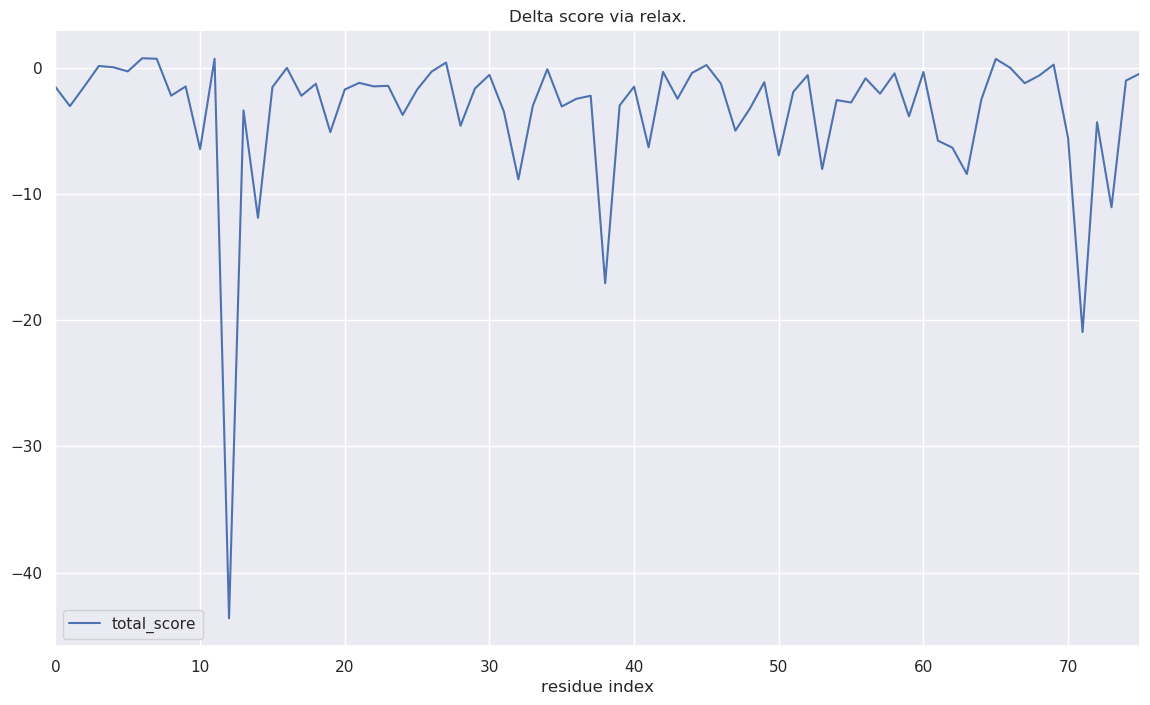

In [7]:
# Pose energies are available under the energies *_energies_array accessor functions.

source_energies = scored_ubq.pose.energies()
relaxed_energies = relaxed_ubq.pose.energies()
display(relaxed_energies.residue_onebody_energies_array().dtype)

source_frame = pandas.DataFrame.from_records(source_energies.residue_total_energies_array())
relaxed_frame = pandas.DataFrame.from_records(relaxed_energies.residue_total_energies_array())

delta = relaxed_frame - source_frame
delta.index.name="residue index"
delta[["total_score"]].plot(title="Delta score via relax.")

We also integrated existing documentation into the pyrosetta.distributed.docs namespace to allow introspection-based exploration of Mover and Filter 

In [8]:
import pyrosetta.distributed.docs as docs
display(dir(docs.filters)[15:20])
display(docs.filters.ChainBreak)

['BuriedUnsatHbonds',
 'CalculatorFilter',
 'ChainBreak',
 'ChainCountFilter',
 'ChainExists']

INFORMATION ABOUT FILTER "ChainBreak":

DESCRIPTION:

Measures the number of chainBreaks in the pose

USAGE:

<ChainBreak threshold=(int,"1") chain_num=(int,"1") tolerance=(real,"0.13") name=(string) confidence=(real,"1.0")>
</ChainBreak>

OPTIONS:

"ChainBreak" tag:

	threshold (int,"1"):  Number of chainbreaks allowed

	chain_num (int,"1"):  which chain should we check for

	tolerance (real,"0.13"):  the allowed angstrom deviation from the mean optimal bond length

	name (string):  The name given to this instance.

	confidence (real,"1.0"):  Probability that the pose will be filtered out if it does not pass this Filter



RosettaScripts components. Existing tools for web-based biomolecular visualization, such as `py3dmol` and `NGLview` extend this interface to a fully-featured biomolecular simulation, analysis, and visualization environment. (Fig 5)

In [9]:
import py3Dmol
view = py3Dmol.view(linked=False, width=600, height=600)
view.addModel( io.to_pdbstring(relaxed_ubq), "pdb")
view.setStyle({'stick':{}})
view.addStyle({'cartoon':{}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Multithreaded and Distributed Execution
Remote notebook execution has the distinct advantage of allowing a user to access computational resources far beyond the capabilities of a single workstation. By using tools such as Dask via the integrations described above, a remote notebook interface can be used to manage a distributed simulation spanning hundreds of cores for rapid model analysis, and it offers a viable alternative to traditional batch-based computing for some classes of simulation. 

In [10]:
import dask
import dask.distributed

# Establish a single-node cluster of worker processes.
# See dask.distributed documentation for multi-node cluster tools.
cluster = dask.distributed.Client(dask.distributed.LocalCluster())
print(cluster)

<Client: scheduler='tcp://127.0.0.1:40888' processes=8 cores=48>


Rosetta-based simulations frequently involve execution of a large number of independent monte-carlo sampling trajectories that all begin from a single starting structure; in other words, they are “embarrassingly” or “trivially” parallel. The Rosetta suite implements a job distribution framework to manage I/O and task scheduling for parallelizable workloads of this type; this allows the rosetta_scripts interpreter to operate as a single process or within MPI, BOINC, and other distributed computing frameworks. Semantics of the RosettaScripts language have also evolved to incorporate non-trivial forms of parallelism, including support for multi-stage scatter/gather protocols. Though fully functional, this framework is optimized for operation as a standalone application and does not provide straightforward integration with third party tools or generalized program logic.

The combination of immutable data structures and pure function interfaces implemented in the pyrosetta.distributed namespace provides an alternative approach to job parallelization by integrating RosettaScripts as a submodule that is compatible with dask.distributed and other task-based distributed computing frameworks. By virtue of reliance on standard python primitives, the `pyrosetta.distributed` namespace is not tightly coupled to a single execution engine. Single-node scheduling may be managed via the standard `multiprocessing` or `concurrent.futures` interfaces, providing a zero-dependency solution for small-scale sampling or analysis tasks. Execution via MPI-based HPC deployments may be managed via the `mpi4py` interface.

To support effective distributed execution, the pyrosetta.distributed namespace is intended to be installed via a build configuration of PyRosetta, provided by conda packages described above, supporting multithreaded execution. This variant utilizes existing work establishing thread-safety in the suite, and it releases the CPython global interpreter lock when calling compiled Rosetta interfaces. This enables multi-core concurrent execution of independent modeling trajectories via python-managed threads, as well as python-level operations such as network I/O and process heartbeats to occur concurrently with long-running Rosetta API calls.

In [11]:
# A "delayed" task is distributed on the worker clusters
delayed_relax = dask.delayed(rosetta_scripts.SingleoutputRosettaScriptsTask("""
    <ROSETTASCRIPTS>
    <SCOREFXNS> </SCOREFXNS>
    <TASKOPERATIONS></TASKOPERATIONS>
    <FILTERS></FILTERS>
    <MOVERS>
      <FastRelax name="fastrelax" repeats="1" />
    </MOVERS>
    <PROTOCOLS>
      <Add mover="fastrelax"/>
    </PROTOCOLS>
    </ROSETTASCRIPTS>
"""))
relax_tasks = [delayed_relax(ubq) for _ in range(64)]
display(relax_tasks[:3])

[Delayed('SingleoutputRosettaScriptsTask(protocol_xml = \'\\n    <ROSETTASCRIPTS>\\n    <SCOREFXNS> </SCOREFXNS>\\n    <TASKOPERATIONS></TASKOPERATIONS>\\n    <FILTERS></FILTERS>\\n    <MOVERS>\\n      <FastRelax name="fastrelax" repeats="1" />\\n    </MOVERS>\\n    <PROTOCOLS>\\n      <Add mover="fastrelax"/>\\n    </PROTOCOLS>\\n    </ROSETTASCRIPTS>\\n\')-bc7d516c-6955-4e22-a22e-48a279f4c541'),
 Delayed('SingleoutputRosettaScriptsTask(protocol_xml = \'\\n    <ROSETTASCRIPTS>\\n    <SCOREFXNS> </SCOREFXNS>\\n    <TASKOPERATIONS></TASKOPERATIONS>\\n    <FILTERS></FILTERS>\\n    <MOVERS>\\n      <FastRelax name="fastrelax" repeats="1" />\\n    </MOVERS>\\n    <PROTOCOLS>\\n      <Add mover="fastrelax"/>\\n    </PROTOCOLS>\\n    </ROSETTASCRIPTS>\\n\')-5885becc-e258-42e7-bdba-8acf92ec2727'),
 Delayed('SingleoutputRosettaScriptsTask(protocol_xml = \'\\n    <ROSETTASCRIPTS>\\n    <SCOREFXNS> </SCOREFXNS>\\n    <TASKOPERATIONS></TASKOPERATIONS>\\n    <FILTERS></FILTERS>\\n    <MOVERS>\\n  

In [12]:
# Persist, beginning computation on the distributed cluster.
relax_tasks, = dask.persist(relax_tasks)

In [13]:
# Multi-threaded worker processes begin a distributed relax.
!top -bn1 | head -n 20

top - 21:42:52 up  3:06,  0 users,  load average: 0.12, 0.08, 0.30
Tasks: 636 total,   7 running, 629 sleeping,   0 stopped,   0 zombie
%Cpu(s):  1.0 us,  0.0 sy,  0.0 ni, 98.9 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 19383412+total, 18696489+free,  3417512 used,  3451716 buff/cache
KiB Swap:        0 total,        0 free,        0 used. 18897763+avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
20246 lexaf     20   0 1614576 442568 198956 R  81.2  0.2   0:01.59 python
20250 lexaf     20   0 1615360 441368 198936 R  81.2  0.2   0:01.59 python
20252 lexaf     20   0 1613520 439736 198764 S  81.2  0.2   0:01.60 python
20254 lexaf     20   0 1610652 437384 198760 S  81.2  0.2   0:01.60 python
20260 lexaf     20   0 1614328 442196 198952 R  81.2  0.2   0:01.58 python
20248 lexaf     20   0 1616860 439768 198928 R  75.0  0.2   0:01.59 python
20256 lexaf     20   0 1613540 441372 198936 R  75.0  0.2   0:01.58 python
20258 lexaf     20   0 1614572

In [14]:
# Compute, pulling results from workers when completed.
relax_results, = dask.compute(relax_tasks)

In [15]:
relax_result_frame = pandas.DataFrame.from_records(packed_pose.to_dict(relax_results))
display(relax_result_frame)
display(relax_result_frame.describe())

,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_intra_sol_xover4,lk_ball_wtd,fa_elec,pro_close,hbond_sr_bb,hbond_lr_bb,...,hbond_sc,dslf_fa13,omega,fa_dun,p_aa_pp,yhh_planarity,ref,rama_prepro,total_score,pickled_pose
0,-414.533548,87.017880,240.935466,171.634621,13.561212,-8.316931,-138.802121,0.137294,-21.396509,-24.637263,...,-9.842593,0.0,14.882225,141.846081,-28.810877,0.001671,11.88443,-25.225484,-236.875258,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
1,-417.616036,89.665402,250.540932,172.235600,14.865754,-8.941395,-143.729947,0.115414,-22.292130,-25.138046,...,-11.709581,0.0,13.564104,147.703490,-26.779853,0.005146,11.88443,-24.831541,-233.748825,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
2,-416.037696,86.559167,241.219787,171.872161,13.114300,-9.171195,-133.330778,0.140058,-21.338510,-24.602856,...,-9.847375,0.0,14.890717,137.678186,-28.645664,0.001622,11.88443,-25.542342,-236.950268,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
3,-413.652532,86.523066,241.708757,173.253910,13.964998,-8.175880,-139.544256,0.134523,-21.332893,-24.553072,...,-9.870090,0.0,14.423985,139.206573,-28.524840,0.004676,11.88443,-25.556470,-237.413003,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
4,-405.057865,83.600478,250.550884,164.492798,14.157138,-10.255674,-143.107407,0.130500,-21.819339,-24.785927,...,-10.575684,0.0,10.606302,132.080317,-26.993373,0.009503,11.88443,-24.741133,-232.844306,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-412.849655,82.278599,256.142183,170.457006,12.826256,-8.202753,-141.328995,0.075621,-21.420823,-24.372237,...,-9.589471,0.0,14.844322,123.350891,-27.365344,0.001342,11.88443,-28.595809,-241.388086,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
60,-417.564965,85.638752,251.586095,167.494238,14.068854,-7.520947,-146.342724,0.112407,-21.603107,-24.666775,...,-12.079606,0.0,15.722080,128.969237,-27.488374,0.003522,11.88443,-25.949225,-250.929621,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
61,-406.718309,81.164953,250.565289,167.861354,14.206585,-7.785318,-145.653755,0.138510,-21.896157,-25.440506,...,-10.826315,0.0,13.309296,127.432946,-27.171071,0.001769,11.88443,-25.857702,-244.112752,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
62,-405.338717,81.308925,242.362518,170.440913,13.111082,-8.250842,-138.932886,0.111431,-21.123840,-25.344347,...,-13.252032,0.0,14.103101,133.353189,-26.221917,0.000495,11.88443,-23.497958,-238.356824,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...


,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_intra_sol_xover4,lk_ball_wtd,fa_elec,pro_close,hbond_sr_bb,hbond_lr_bb,hbond_bb_sc,hbond_sc,dslf_fa13,omega,fa_dun,p_aa_pp,yhh_planarity,ref,rama_prepro,total_score
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,6.400000e+01,64.000000,64.000000
mean,-412.398387,84.666632,248.952723,170.862718,13.487279,-8.242926,-141.890999,0.120264,-21.631658,-24.815269,-12.999627,-10.933493,0.0,14.296867,131.351531,-27.525743,0.012438,1.188443e+01,-25.539245,-241.352149
std,5.092030,2.458225,4.847316,5.344470,0.701480,0.826497,3.770203,0.045677,0.416049,0.448841,1.457342,1.333651,0.0,2.064210,7.313366,0.896768,0.063118,1.790399e-15,1.268865,5.138987
min,-421.896957,79.929049,240.367470,161.357663,12.286200,-10.388430,-150.225241,0.059318,-22.643724,-25.658065,-16.354001,-14.217683,0.0,8.937707,115.768251,-29.941382,0.000002,1.188443e+01,-29.497474,-253.163619
25%,-416.177728,82.952851,245.247657,167.170257,12.843353,-8.705077,-144.755154,0.092470,-21.936929,-25.122118,-13.891951,-12.075459,0.0,12.979226,125.540210,-27.927236,0.001317,1.188443e+01,-26.209107,-244.884977
50%,-412.698555,84.353729,249.709019,170.461304,13.616494,-8.236696,-142.395310,0.112472,-21.694169,-24.795306,-13.215612,-10.685479,0.0,14.532800,131.981932,-27.447900,0.002730,1.188443e+01,-25.549406,-241.091948
75%,-407.814401,86.110133,251.954614,174.033605,14.086546,-7.673382,-139.732880,0.132240,-21.382692,-24.576877,-11.952388,-9.853509,0.0,15.829100,136.166153,-26.838487,0.006090,1.188443e+01,-24.869320,-237.144055
max,-400.185799,90.215249,257.739908,185.313015,14.865754,-6.772219,-131.305415,0.338816,-20.472891,-22.606144,-9.671601,-7.805468,0.0,18.443958,147.703490,-26.136842,0.507180,1.188443e+01,-21.722543,-230.463111
